In [ ]:
# Install required packages
!pip install torch transformers datasets accelerate
!pip install -q -U transformers accelerate bitsandbytes safetensors
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 94.5 MB/s eta 0:00:00
  

In [ ]:
# ======================
# Imports
# ======================
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset
import math
import logging
import sys
from typing import Dict, Any
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import gc
import time
import traceback
import functools
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Configuration
# ======================
CONFIG = {
    'NUM_BITS': 4,              # 4-bit quantization
    'GROUP_SIZE': 128,          # Grouping for quantization
    'PERCENTILE': 0.9995,       # Manage outliers effectively
    'MAX_LENGTH': 2048,         # Standard evaluation token length
    'CALIB_SAMPLES': 16,        # Default calibration samples
    'BATCH_SIZE': 8,            # Safe for resource-limited environments
    'EVAL_SAMPLES': 1000,       # Sufficient for reliable evaluation
    'CLEAR_CACHE_FREQ': 100,    # Prevent memory overflow
    'MODEL_ID': "facebook/opt-350m",  # OPT-350M model
    'TRAINING_CONFIGS': [
        # Baseline configuration
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.0}, # SAME PPL

        # Group Size Variations
        {'group_size': 64, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.0},
        {'group_size': 32, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.0},
        {'group_size': 256, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.0},
        {'group_size': 16, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.0}, # SAME PPL

        # Percentile Variations
        {'group_size': 128, 'percentile': 0.9999, 'importance_threshold': 0.95, 'scale_factor': 1.0},
        {'group_size': 128, 'percentile': 0.999, 'importance_threshold': 0.95, 'scale_factor': 1.0},
        {'group_size': 128, 'percentile': 0.998, 'importance_threshold': 0.95, 'scale_factor': 1.0},

        # Importance Threshold Variations
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.90, 'scale_factor': 1.0},
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.99, 'scale_factor': 1.0},
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.97, 'scale_factor': 1.0},

        # Scale Factor Variations
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 0.8},
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.2},
        {'group_size': 128, 'percentile': 0.9995, 'importance_threshold': 0.95, 'scale_factor': 1.5},

        # Combined Variations for Edge Cases
        {'group_size': 64, 'percentile': 0.999, 'importance_threshold': 0.97, 'scale_factor': 1.2},
        {'group_size': 32, 'percentile': 0.9999, 'importance_threshold': 0.90, 'scale_factor': 0.8}
    ]
}

# ======================
# Logging Setup
# ======================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# ======================
# CUDA Check
# ======================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ======================
# Error Handling Decorator
# ======================
def handle_gpu_errors(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except RuntimeError as e:
            if "out of memory" in str(e):
                torch.cuda.empty_cache()
            logging.error(f"Error in {func.__name__}: {str(e)}")
            raise
    return wrapper

CUDA available: True
GPU: NVIDIA L4


In [ ]:
class W4A4Quantizer:
    """
    Implements W4A4 quantization with activation-aware weight quantization (AWQ).
    Handles both weight and activation quantization in 4-bit precision.
    """
    def __init__(self, base_group_size=128, percentile=0.9995, importance_threshold=0.95, scale_factor=1.0):
        self.base_group_size = base_group_size
        self.percentile = percentile
        self.importance_threshold = importance_threshold
        self.scale_factor = scale_factor
        self.num_bits = 4
        self.max_value = 2 ** self.num_bits - 1  # Maximum value for 4-bit quantization
        self.chunk_size = min(4096, base_group_size * 32)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dtype = torch.float16
        self.activation_stats = {}
        self.min_scale = 1e-5
        self.layer_configs = {}

    def compute_dynamic_group_size(self, layer_name, weights):
        """Compute optimal group size based on layer characteristics"""
        if layer_name in self.layer_configs:
            return self.layer_configs[layer_name]['group_size']

        # Convert weights to float32 for analysis
        weights_fp32 = weights.to(torch.float32)
        abs_weights = torch.abs(weights_fp32)
        mean_magnitude = torch.mean(abs_weights)
        std_magnitude = torch.std(abs_weights)
        sparsity = torch.sum(abs_weights < 0.01) / abs_weights.numel()

        # Dynamic group size logic
        base_size = self.base_group_size
        if 'attention' in layer_name.lower():
            # Smaller groups for attention layers
            group_size = max(32, int(base_size * 0.5))
        elif sparsity > 0.7:
            # Larger groups for sparse layers
            group_size = min(256, int(base_size * 1.5))
        elif std_magnitude > mean_magnitude * 2:
            # Smaller groups for high variance
            group_size = max(32, int(base_size * 0.75))
        else:
            group_size = base_size

        # Ensure group size is power of 2
        group_size = 2 ** int(np.log2(group_size))

        # Cache configuration
        self.layer_configs[layer_name] = {
            'group_size': group_size,
            'is_attention': 'attention' in layer_name.lower()
        }

        return group_size

    @handle_gpu_errors
    def compute_weight_importance(self, weights, activations):
        """Compute importance scores for weights based on activation patterns"""
        try:
            orig_w_shape = weights.shape
            orig_a_shape = activations.shape

            # Ensure device and dtype
            weights = weights.to(self.device, self.dtype)
            activations = activations.to(self.device, self.dtype)

            # Reshape weights to 2D
            weights_2d = weights.reshape(-1, weights.shape[-1])

            with torch.no_grad():
                # Normalize weights
                w_norm = F.normalize(weights_2d, dim=1)

                # Process activations
                if len(activations.shape) == 3:
                    flat_activations = activations.reshape(-1, activations.shape[-1])
                else:
                    flat_activations = activations

                # Normalize activations
                act_mean = flat_activations.mean(dim=0, keepdim=True)
                act_std = flat_activations.std(dim=0, keepdim=True).clamp(min=1e-5)
                act_norm = F.normalize((flat_activations - act_mean) / act_std, dim=1)

                # Compute importance scores
                importance = torch.abs(torch.matmul(w_norm, act_norm.t()))
                importance = importance.mean(dim=1, keepdim=True)

                # Reshape importance scores
                importance = importance.reshape(orig_w_shape[0], 1)

                return importance

        except Exception as e:
            logging.error(f"Error in compute_weight_importance: {str(e)}")
            logging.error(f"Weight shape: {orig_w_shape}, Activation shape: {orig_a_shape}")
            raise

    @handle_gpu_errors
    def quantize_weight_matrix_awq(self, weights, activations, layer_name=""):
        """Quantize weights using activation-aware quantization"""
        try:
            weights = weights.to(self.dtype)
            activations = activations.to(self.dtype)
            original_shape = weights.shape

            # Get dynamic group size and attention flag
            group_size = self.compute_dynamic_group_size(layer_name, weights)
            is_attention = self.layer_configs[layer_name]['is_attention']

            # Reshape weights to 2D
            weights_2d = weights.reshape(weights.shape[0], -1)

            # Compute importance scores
            importance_scores = self.compute_weight_importance(weights_2d, activations)
            importance_scores = importance_scores.to(torch.float32)

            # Set threshold based on layer type
            if is_attention:
                threshold = torch.quantile(importance_scores, max(0.99, self.importance_threshold))
            else:
                threshold = torch.quantile(importance_scores, self.importance_threshold)

            important_mask = (importance_scores >= threshold).to(self.device)

            # Setup for group quantization
            num_rows = weights_2d.shape[0]
            num_cols = weights_2d.shape[1]
            num_groups = (num_cols + group_size - 1) // group_size
            padded_size = num_groups * group_size

            # Pad if necessary
            if padded_size != num_cols:
                weights_2d = F.pad(weights_2d, (0, padded_size - num_cols))

            # Reshape for group processing
            weights_grouped = weights_2d.reshape(num_rows, num_groups, group_size)
            quantized_weights = torch.zeros_like(weights_grouped)

            # Process each group
            for group_idx in range(num_groups):
                group = weights_grouped[:, group_idx, :]
                group_mask = important_mask.squeeze()

                # Handle important weights
                if group_mask.any():
                    imp_weights = group[group_mask]
                    scale_factor = self.scale_factor * (1.2 if is_attention else 1.0)
                    imp_scale = self._compute_scale_factor(imp_weights) * scale_factor
                    imp_scaled = imp_weights / imp_scale
                    imp_clipped = torch.clamp(imp_scaled, -self.max_value, self.max_value)
                    imp_quant = torch.round(imp_clipped) * imp_scale
                    quantized_weights[:, group_idx, :][group_mask] = imp_quant

                # Handle other weights
                if (~group_mask).any():
                    other_weights = group[~group_mask]
                    other_scale = self._compute_scale_factor(other_weights)
                    other_scaled = other_weights / other_scale
                    other_clipped = torch.clamp(other_scaled, -self.max_value, self.max_value)
                    other_quant = torch.round(other_clipped) * other_scale
                    quantized_weights[:, group_idx, :][~group_mask] = other_quant

            # Reshape back and remove padding
            quantized_weights = quantized_weights.reshape(num_rows, padded_size)
            if padded_size != num_cols:
                quantized_weights = quantized_weights[:, :num_cols]

            return quantized_weights.reshape(original_shape).to(self.dtype)

        except Exception as e:
            logging.error(f"Error in quantize_weight_matrix_awq: {str(e)}")
            raise

    @handle_gpu_errors
    def quantize_activation(self, x, layer_name=""):
        """Enhanced activation quantization with attention-aware processing"""
        try:
            x = x.to(self.dtype)
            original_shape = x.shape

            # Get layer configuration
            is_attention = layer_name in self.layer_configs and self.layer_configs[layer_name]['is_attention']
            group_size = self.compute_dynamic_group_size(layer_name, x)

            # Special handling for attention layers
            if is_attention:
                # Use higher precision for attention scores
                if len(x.shape) == 3:  # [batch_size, seq_len, hidden_dim]
                    return self._quantize_attention_activation(x)

            # Standard quantization for other layers
            if len(x.shape) == 3:
                B, L, H = x.shape
                x_reshaped = x.reshape(-1, group_size)
            else:
                x_reshaped = x.reshape(-1, group_size)

            # Compute scales per group
            scales = self._compute_scale_factor(x_reshaped, dim=1)
            scales = scales.unsqueeze(1).expand(-1, group_size)

            # Quantize
            x_scaled = x_reshaped / scales.clamp(min=self.min_scale)
            x_clipped = torch.clamp(x_scaled, -self.max_value, self.max_value)
            x_rounded = torch.round(x_clipped)
            x_dequant = x_rounded * scales

            # Reshape back
            x_final = x_dequant.reshape(original_shape)

            return x_final.to(self.dtype)

        except Exception as e:
            logging.error(f"Error in quantize_activation: {str(e)}")
            raise

    @handle_gpu_errors
    def _quantize_attention_activation(self, x):
        """Special quantization for attention activations with per-head processing"""
        try:
            B, L, H = x.shape

            # Split head dimension for multi-head attention
            num_heads = 8  # Standard number of heads
            head_dim = H // num_heads
            x_heads = x.reshape(B, L, num_heads, head_dim)

            # Quantize each head separately with higher precision
            x_quantized = []
            for head_idx in range(num_heads):
                head = x_heads[:, :, head_idx, :]

                # Use reduced group size for attention heads
                group_size = min(32, head.shape[-1])
                head_reshaped = head.reshape(-1, group_size)

                # Compute scales with higher percentile for attention
                scales = self._compute_scale_factor(head_reshaped, dim=1, percentile=0.9999)
                scales = scales.unsqueeze(1).expand(-1, group_size)

                # Quantize with reduced noise
                head_scaled = head_reshaped / scales.clamp(min=self.min_scale)
                head_clipped = torch.clamp(head_scaled, -self.max_value, self.max_value)
                head_rounded = torch.round(head_clipped)
                head_dequant = head_rounded * scales

                # Reshape back
                x_quantized.append(head_dequant.reshape(B, L, head_dim))

            # Concatenate heads and reshape
            x_final = torch.stack(x_quantized, dim=2).reshape(B, L, H)
            return x_final.to(self.dtype)

        except Exception as e:
            logging.error(f"Error in _quantize_attention_activation: {str(e)}")
            raise

    def _compute_scale_factor(self, x, dim=None, percentile=None):
        """Compute scale factor with optional custom percentile for different quantization needs"""
        if percentile is None:
            percentile = self.percentile

        with torch.no_grad():
            x = x.to(self.dtype)
            abs_x = torch.abs(x)

            if dim is not None:
                max_val = torch.quantile(abs_x.float(), percentile, dim=dim, keepdim=True)
            else:
                max_val = torch.quantile(abs_x.float(), percentile)

            scale = torch.clamp(max_val / self.max_value, min=self.min_scale)
            return scale.to(self.dtype)

    def get_memory_footprint(self, model):
        """Calculate memory metrics for the quantized model"""
        try:
            total_params = sum(p.numel() for p in model.parameters())
            total_size_fp16 = total_params * 2  # 2 bytes per parameter for fp16
            total_size_w4a4 = total_params * 0.5  # 0.5 bytes per parameter for 4-bit

            memory_metrics = {
                'original_size_mb': total_size_fp16 / (1024 * 1024),
                'quantized_size_mb': total_size_w4a4 / (1024 * 1024),
                'memory_savings_percentage': (1 - (total_size_w4a4 / total_size_fp16)) * 100,
                'total_parameters': total_params
            }

            return memory_metrics

        except Exception as e:
            logging.error(f"Error calculating memory footprint: {str(e)}")
            return None

In [ ]:
class QuantizedOPT(nn.Module):
    """
    Wrapper class for OPT model with W4A4 quantization support.
    Handles model calibration and forward pass with quantization.
    """
    def __init__(self, model, quantizer, calibrate=True, calib_data=None):
        super().__init__()
        self.model = model
        self.quantizer = quantizer
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.dtype = torch.float16

        self.model.to(self.device)
        if calibrate and calib_data is not None:
            calib_data = {k: v.to(self.device) for k, v in calib_data.items()}
            self.calibrate(calib_data)

    @handle_gpu_errors
    def _collect_activations(self, calib_data):
        """Collect activation statistics for calibration"""
        activations_dict = {}
        hooks = []

        def hook_fn(name):
            def hook(module, input, output):
                if input[0].numel() > 0:
                    input_data = input[0].detach()
                    activations_dict[f"{name}_input"] = input_data
                    torch.cuda.empty_cache()
            return hook

        # Register hooks for all relevant layers
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Linear, nn.LayerNorm)):
                hooks.append(module.register_forward_hook(hook_fn(name)))

        try:
            with torch.no_grad():
                self.model(**calib_data)
        finally:
            for hook in hooks:
                hook.remove()

        return activations_dict

    @handle_gpu_errors
    def calibrate(self, calib_data):
        """Calibrate the model using activation-aware quantization"""
        print("Starting layer-aware AWQ calibration...")

        try:
            with torch.no_grad():
                activations_dict = self._collect_activations(calib_data)

                for name, module in self.model.named_modules():
                    if isinstance(module, nn.Linear) and hasattr(module, 'weight'):
                        act_key = f"{name}_input"
                        if act_key in activations_dict:
                            activations = activations_dict[act_key].to(self.device)
                            module.weight.data = module.weight.data.to(self.device)

                            # Quantize with layer name for dynamic configuration
                            quantized_weight = self.quantizer.quantize_weight_matrix_awq(
                                module.weight.data,
                                activations,
                                layer_name=name
                            )
                        else:
                            logging.warning(f"No activation data for {name}")
                            quantized_weight = self.quantizer.quantize_weight_matrix_awq(
                                module.weight.data,
                                torch.ones(1, module.weight.data.size(1), device=self.device),
                                layer_name=name
                            )

                        module.weight.data = quantized_weight

                        if module.bias is not None:
                            module.bias.data = module.bias.data.to(self.device).to(self.quantizer.dtype)

                        torch.cuda.empty_cache()

            print("Layer-aware AWQ calibration completed successfully")

        except Exception as e:
            logging.error(f"Error during calibration: {str(e)}")
            raise

        finally:
            torch.cuda.empty_cache()

    @handle_gpu_errors
    def forward(self, input_ids, attention_mask=None, **kwargs):
        """Forward pass with layer-specific quantization"""
        def quantize_attention_module(name, module):
            if isinstance(module, nn.Linear):
                def hook(module, input_tensor, output):
                    return self.quantizer.quantize_activation(output, layer_name=name)
                return hook

        hooks = []
        try:
            # Add hooks for attention-specific quantization
            for name, module in self.model.named_modules():
                if 'attention' in name.lower() and isinstance(module, nn.Linear):
                    hooks.append(module.register_forward_hook(quantize_attention_module(name, module)))

            with torch.amp.autocast('cuda', enabled=True):
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

            return outputs

        finally:
            for hook in hooks:
                hook.remove()

    def _apply_mixed_precision(self, tensor, is_attention=False):
        """Apply mixed precision based on layer type"""
        if is_attention:
            # Use higher precision for attention computations
            if tensor.dtype != torch.float16:
                tensor = tensor.to(torch.float16)
        else:
            # Use regular W4A4 quantization
            tensor = self.quantizer.quantize_activation(tensor)
        return tensor

    @handle_gpu_errors
    def generate(self, input_ids, attention_mask=None, **kwargs):
        """Text generation with mixed precision handling"""
        try:
            hooks = []

            def attention_hook(name):
                def hook(module, input_tensor, output):
                    return self._apply_mixed_precision(output, is_attention=True)
                return hook

            # Register hooks only for attention modules
            for name, module in self.model.named_modules():
                if 'attention' in name.lower() and isinstance(module, nn.Linear):
                    hooks.append(module.register_forward_hook(attention_hook(name)))

            try:
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    **kwargs
                )
                return outputs
            finally:
                for hook in hooks:
                    hook.remove()

        except Exception as e:
            logging.error(f"Error during generation: {str(e)}")
            raise

    def to(self, device):
        """Move model to specified device"""
        self.device = device
        self.model.to(device)
        return self

    def save_model(self, save_path="w4a4_optimized_model"):
        """Save the quantized model with layer configurations"""
        try:
            os.makedirs(save_path, exist_ok=True)

            # Save model state
            model_state = {
                'model_state_dict': self.model.state_dict(),
                'quantizer_config': {
                    'base_group_size': self.quantizer.base_group_size,
                    'num_bits': self.quantizer.num_bits,
                    'max_value': self.quantizer.max_value,
                    'chunk_size': self.quantizer.chunk_size,
                    'percentile': self.quantizer.percentile,
                    'layer_configs': self.quantizer.layer_configs
                }
            }
            torch.save(model_state, os.path.join(save_path, 'model_state.pt'))

            # Save configuration
            config = {
                'num_bits': self.quantizer.num_bits,
                'base_group_size': self.quantizer.base_group_size,
                'quantization_type': 'w4a4_mixed',
                'model_type': 'opt',
                'dtype': str(self.dtype),
                'device': str(self.device),
                'layer_specific_configs': {
                    name: {
                        'group_size': cfg['group_size'],
                        'is_attention': cfg['is_attention']
                    }
                    for name, cfg in self.quantizer.layer_configs.items()
                }
            }

            with open(os.path.join(save_path, 'config.json'), 'w') as f:
                json.dump(config, f, indent=4)

            print(f"\nModel saved successfully to {save_path}")
            print(f"Configuration saved to {os.path.join(save_path, 'config.json')}")

        except Exception as e:
            logging.error(f"Error saving model: {str(e)}")
            raise

In [ ]:
# ======================
# Data Preparation
# ======================
@handle_gpu_errors
def prepare_calibration_data(tokenizer, num_samples=CONFIG['CALIB_SAMPLES'], max_length=CONFIG['MAX_LENGTH']):
    """Prepare calibration data for both weight and activation quantization"""
    try:
        # Load and preprocess dataset
        dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train[:1%]')
        texts = [text for text in dataset['text'] if text.strip()][:num_samples]

        # Clean and preprocess texts
        cleaned_texts = []
        for text in texts:
            # Basic cleaning
            text = text.strip()
            # Remove non-English content
            text = ''.join(c for c in text if ord(c) < 128)
            cleaned_texts.append(text)

        # Tokenize texts
        inputs = tokenizer(
            cleaned_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        logging.info(f"Prepared calibration data with {len(cleaned_texts)} samples")
        return inputs

    except Exception as e:
        logging.error(f"Error in prepare_calibration_data: {str(e)}")
        raise

# ======================
# Evaluation Functions
# ======================
@handle_gpu_errors
def evaluate_perplexity(model, tokenizer, model_type="", num_runs=1, seed=42):
    """Evaluate perplexity with consistent state management"""
    print(f"\nEvaluating {model_type} model perplexity...")

    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

    try:
        # Load dataset once and cache
        dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='validation')
        texts = [text for text in dataset["text"] if text.strip()]
        full_text = " ".join(texts)

        # Tokenize once and cache
        print("Tokenizing text...")
        encodings = tokenizer(full_text, return_tensors="pt")
        input_ids = encodings['input_ids']

        perplexity_scores = []

        for run in range(num_runs):
            # Clear memory and reset model state
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

            # Move model to CPU and back to reset states
            device = model.device
            model.cpu()
            if hasattr(model, 'model'):
                model.model.cpu()
            torch.cuda.empty_cache()

            model.to(device)
            if hasattr(model, 'model'):
                model.model.to(device)

            # Move input_ids to device
            current_input_ids = input_ids.to(device)

            try:
                stride = 512
                seq_len = CONFIG['MAX_LENGTH']
                nlls = []

                n_steps = (current_input_ids.size(1) - 1) // stride + 1

                progress_bar = tqdm(
                    range(0, current_input_ids.size(1), stride),
                    desc=f"{model_type} PPL Run {run + 1}",
                    total=n_steps,
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, ppl={postfix[0]:.2f}]',
                    postfix=[0.0]
                )

                for i in progress_bar:
                    begin_loc = max(i + seq_len - stride, 0)
                    end_loc = min(i + seq_len, current_input_ids.size(1))
                    target_len = end_loc - i

                    chunk_input_ids = current_input_ids[:, i:end_loc]

                    with torch.no_grad():
                        outputs = model(chunk_input_ids)
                        shift_logits = outputs.logits[..., :-1, :].contiguous()
                        shift_labels = chunk_input_ids[..., 1:].contiguous()

                        loss_fct = nn.CrossEntropyLoss(reduction='none')
                        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                                      shift_labels.view(-1))

                        if i != 0:
                            loss = loss[-target_len:]

                        nlls.append(loss)

                        if len(nlls) > 0:
                            current_nll = torch.cat(nlls).mean()
                            current_ppl = torch.exp(current_nll).item()
                            progress_bar.postfix[0] = current_ppl

                        # Clear cache periodically
                        if i % CONFIG['CLEAR_CACHE_FREQ'] == 0:
                            torch.cuda.empty_cache()

                nll = torch.cat(nlls).mean()
                ppl = torch.exp(nll).item()
                perplexity_scores.append(ppl)
                print(f"Run {run + 1} Perplexity: {ppl:.4f}")

            except RuntimeError as e:
                print(f"Error during evaluation run {run + 1}: {str(e)}")
                return float('inf'), 0.0, []

        # Calculate statistics
        mean_ppl = sum(perplexity_scores) / len(perplexity_scores)
        std_ppl = np.std(perplexity_scores) if len(perplexity_scores) > 1 else 0.0

        print(f"\n{model_type} Final Results:")
        print(f"Mean Perplexity: {mean_ppl:.4f}")
        # print(f"Std Deviation: {std_ppl:.4f}")
        print(f"Individual Runs: {', '.join(f'{x:.4f}' for x in perplexity_scores)}")

        return mean_ppl, std_ppl, perplexity_scores

    except Exception as e:
        logging.error(f"Error in evaluate_perplexity: {str(e)}")
        raise

In [ ]:
# ======================
# Text Generation Functions
# ======================
@handle_gpu_errors
def generate_text(model, tokenizer, prompt, max_length=150):
    """Generate text with proper sampling parameters and device handling"""
    try:
        # Ensure model and inputs are on the same device
        device = next(model.parameters()).device
        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            start_time = time.time()
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                top_k=50,
                num_beams=4,
                no_repeat_ngram_size=3,
                pad_token_id=tokenizer.eos_token_id,
                num_return_sequences=1
            )
            generation_time = time.time() - start_time

        # Move outputs back to CPU for decoding
        outputs = outputs.cpu()
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text, generation_time

    except Exception as e:
        logging.error(f"Error in generate_text: {str(e)}")
        return f"Error generating text: {str(e)}", 0.0

# ======================
# Interactive Demo
# ======================
def interactive_demo(fp16_model, w4a4_model, tokenizer):
    """Interactive demo for comparing FP16 and W4A4 models"""
    print("\n" + "="*50)
    print("Interactive Model Comparison")
    print("="*50)
    print("\nType 'quit' to exit, 'help' for sample prompts, or enter your prompt:")

    # Sample prompts
    sample_prompts = [
        "Write a short story about a robot learning to paint.",
        "Explain how photosynthesis works to a 10-year-old.",
        "Describe three major differences between classical and quantum physics.",
        "What might cities look like in the year 2100?",
        "How does machine learning differ from traditional programming?"
    ]

    @handle_gpu_errors
    def generate_response(model, prompt, max_new_tokens=200):
        """Generate text with specified parameters"""
        try:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            with torch.no_grad():
                start_time = time.time()
                outputs = model.generate(
                    **inputs,
                    max_length=len(inputs["input_ids"][0]) + max_new_tokens,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.92,
                    top_k=50,
                    num_beams=4,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    num_return_sequences=1,
                    repetition_penalty=1.2
                )
                generation_time = time.time() - start_time

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            # Remove the prompt from the response
            response = response[len(prompt):].strip()
            return response, generation_time

        except Exception as e:
            logging.error(f"Error during generation: {str(e)}")
            return "Error generating response.", 0

    while True:
        print("\nEnter your prompt:", end=" ")
        prompt = input().strip()

        if prompt.lower() == 'quit':
            break

        if prompt.lower() == 'help':
            print("\nSample prompts you can try:")
            for i, sample in enumerate(sample_prompts, 1):
                print(f"{i}. {sample}")
            continue

        if not prompt:
            print("Please enter a prompt or type 'quit' to exit.")
            continue

        print("\nGenerating responses...\n")

        # Generate with FP16 model
        print("FP16 Model Response:")
        print("-" * 40)
        fp16_response, fp16_time = generate_response(fp16_model, prompt)
        print(fp16_response)
        print(f"\nGeneration time: {fp16_time*1000:.2f}ms")

        print("\nW4A4 Model Response:")
        print("-" * 40)
        w4a4_response, w4a4_time = generate_response(w4a4_model, prompt)
        print(w4a4_response)
        print(f"\nGeneration time: {w4a4_time*1000:.2f}ms")

        # Calculate and print similarity
        from difflib import SequenceMatcher
        similarity = SequenceMatcher(None, fp16_response, w4a4_response).ratio()
        print(f"\nResponse Similarity: {similarity*100:.1f}%")

        # Memory stats
        if torch.cuda.is_available():
            print(f"\nGPU Memory Usage:")
            print(f"Allocated: {torch.cuda.memory_allocated()/1024**2:.1f}MB")
            print(f"Cached: {torch.cuda.memory_reserved()/1024**2:.1f}MB")

            # Clear cache between generations
            torch.cuda.empty_cache()

    print("\nInteractive demo completed!")

# ======================
# Metrics Collection
# ======================
@handle_gpu_errors
def collect_comprehensive_metrics(fp16_model, w4a4_model, tokenizer, quantizer, fp16_ppl, w4a4_ppl):
    """Collect comprehensive metrics comparing FP16 and W4A4 models"""
    print("\n" + "="*50)
    print("Comprehensive Model Metrics")
    print("="*50)

    metrics = {}

    try:
        # 1. Memory Metrics
        print("\n1. Memory Footprint Analysis:")
        memory_metrics = quantizer.get_memory_footprint(w4a4_model)
        for metric, value in memory_metrics.items():
            print(f"{metric}: {value:.2f}")
        metrics['memory_metrics'] = memory_metrics

        # 2. Speed Metrics
        print("\n2. Speed Analysis:")
        fp16_time = measure_inference_time(fp16_model, tokenizer)
        w4a4_time = measure_inference_time(w4a4_model, tokenizer)
        speedup = fp16_time / w4a4_time if w4a4_time > 0 else 0

        speed_metrics = {
            'fp16_time': fp16_time,
            'w4a4_time': w4a4_time,
            'speedup': speedup
        }
        metrics['speed_metrics'] = speed_metrics

        print(f"FP16 inference time: {fp16_time*1000:.2f}ms")
        print(f"W4A4 inference time: {w4a4_time*1000:.2f}ms")
        print(f"Speedup: {speedup:.2f}x")

        return metrics

    except Exception as e:
        logging.error(f"Error collecting metrics: {str(e)}")
        return None

@handle_gpu_errors
def measure_inference_time(model, tokenizer, num_runs=20):
    """Measure average inference time over multiple runs"""
    try:
        device = next(model.parameters()).device
        input_text = "This is a sample text for inference timing measurement."
        inputs = tokenizer(input_text, return_tensors="pt").to(device)

        # Warmup
        for _ in range(2):
            with torch.no_grad():
                _ = model(**inputs)
                torch.cuda.synchronize()

        torch.cuda.empty_cache()

        # Timing measurements
        times = []
        for i in range(num_runs):
            with torch.no_grad():
                torch.cuda.synchronize()
                start_time = time.time()
                _ = model(**inputs)
                torch.cuda.synchronize()
                end_time = time.time()
                times.append(end_time - start_time)

            if (i + 1) % 5 == 0:
                torch.cuda.empty_cache()

        # Remove outliers
        times = sorted(times)
        trim_size = int(len(times) * 0.1)
        trimmed_times = times[trim_size:-trim_size] if trim_size > 0 else times

        return sum(trimmed_times) / len(trimmed_times)

    except Exception as e:
        logging.error(f"Error measuring inference time: {str(e)}")
        return 0.0

def save_results(results):
    with open('experiment_results.json', 'w') as f:
        json.dump(results, f, indent=4)

def print_summary(best_config, fp16_mean, best_config_result, best_ppl_diff, metrics):
    print("\nQuantization Pipeline Summary")
    print("="*50)
    print(f"Best Configuration: {best_config}")
    print(f"FP16 Baseline PPL: {fp16_mean:.4f}")
    print(f"Best W4A4 PPL: {best_config_result['perplexity']:.4f}")
    print(f"PPL Difference: {best_ppl_diff:.4f}")
    print(f"Memory Savings: {metrics['memory_metrics']['memory_savings_percentage']:.2f}%")

In [ ]:
def create_visualization(results, fp16_mean, metrics, save_dir="./figures"):
    """
    Create and save visualizations of quantization results.
    """

    os.makedirs(save_dir, exist_ok=True)

    # Color scheme
    BASELINE_COLOR = '#dc2626'  # red
    BEST_COLOR = '#2563eb'      # blue
    CONFIG_COLORS = sns.color_palette("husl", len(results))

    # 1. Configuration Performance Comparison
    fig, ax = plt.subplots(figsize=(12, 6))

    # Sort configurations by perplexity
    sorted_results = sorted(results, key=lambda x: x['perplexity'])
    configs = [f"Config\n{i+1}" for i in range(len(sorted_results))]
    perplexities = [r['perplexity'] for r in sorted_results]

    # Calculate PPL differences
    ppl_diffs = [ppl - fp16_mean for ppl in perplexities]

    # Create bar plot with different colors
    bars = ax.bar(configs, perplexities, color=CONFIG_COLORS)

    # Color the best configuration bar
    bars[0].set_color(BEST_COLOR)

    # Add baseline reference line
    ax.axhline(y=fp16_mean, color=BASELINE_COLOR, linestyle='--', label='FP16 Baseline')

    # Customize plot
    title_text = 'Configuration Performance Comparison\n'
    title_text += f'(Best Config PPL Diff: +{ppl_diffs[0]:.4f}, {(ppl_diffs[0]/fp16_mean)*100:.2f}% degradation)'
    ax.set_title(title_text, pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Perplexity (PPL)')
    ax.set_ylim([min(fp16_mean-1, min(perplexities)-0.5), max(perplexities)+0.7])

    # Add value labels on bars with differences
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}\n(+{ppl_diffs[idx]:.2f})',
                ha='center', va='bottom')

    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'config_performance.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 2. Model Comparison Dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Model Size Comparison
    sizes = [metrics['memory_metrics']['original_size_mb'],
            metrics['memory_metrics']['quantized_size_mb']]
    bars = ax1.bar(['FP16', 'W4A4'], sizes, color=[BASELINE_COLOR, BEST_COLOR])
    ax1.set_title(f'Model Size Comparison\n({metrics["memory_metrics"]["memory_savings_percentage"]:.1f}% reduction)')
    ax1.set_ylabel('Size (MB)')
    for i, v in enumerate(sizes):
        ax1.text(i, v, f'{v:.1f}MB', ha='center', va='bottom')

    # Inference Time Comparison
    times = [metrics['speed_metrics']['fp16_time']*1000,
            metrics['speed_metrics']['w4a4_time']*1000]
    speedup = metrics['speed_metrics']['speedup']
    bars = ax2.bar(['FP16', 'W4A4'], times, color=[BASELINE_COLOR, BEST_COLOR])
    ax2.set_title(f'Inference Time Comparison\n({(1-speedup)*100:.1f}% slower)')
    ax2.set_ylabel('Time (ms)')
    for i, v in enumerate(times):
        ax2.text(i, v, f'{v:.2f}ms', ha='center', va='bottom')

    # Memory Savings Pie Chart
    savings = metrics['memory_metrics']['memory_savings_percentage']
    ax3.pie([savings, 100-savings], labels=['Saved', 'Used'], autopct='%1.1f%%',
            colors=[BEST_COLOR, 'lightgray'])
    ax3.set_title('Memory Savings')

    # Perplexity Comparison
    w4a4_ppl = sorted_results[0]['perplexity']  # Best config perplexity
    perplexities = [fp16_mean, w4a4_ppl]
    ppl_change = ((w4a4_ppl - fp16_mean) / fp16_mean) * 100
    bars = ax4.bar(['FP16', 'W4A4'], perplexities, color=[BASELINE_COLOR, BEST_COLOR])
    ax4.set_title(f'Perplexity Comparison\n({ppl_change:+.1f}% change)')
    ax4.set_ylabel('Perplexity (PPL)')
    for i, v in enumerate(perplexities):
        ax4.text(i, v, f'{v:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'model_comparison.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]


Evaluating FP16-Baseline model perplexity...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing text...


FP16-Baseline PPL Run 1: 100%|██████████| 488/488 [00:21<00:00, ppl=22.06]


Run 1 Perplexity: 22.0625

FP16-Baseline Final Results:
Mean Perplexity: 22.0625
Individual Runs: 22.0625
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-1 model perplexity...
Tokenizing text...


Config-1 PPL Run 1: 100%|██████████| 488/488 [00:23<00:00, ppl=24.23]


Run 1 Perplexity: 24.2344

Config-1 Final Results:
Mean Perplexity: 24.2344
Individual Runs: 24.2344
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-2 model perplexity...
Tokenizing text...


Config-2 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.33]


Run 1 Perplexity: 24.3281

Config-2 Final Results:
Mean Perplexity: 24.3281
Individual Runs: 24.3281
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-3 model perplexity...
Tokenizing text...


Config-3 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.28]


Run 1 Perplexity: 24.2812

Config-3 Final Results:
Mean Perplexity: 24.2812
Individual Runs: 24.2812
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-4 model perplexity...
Tokenizing text...


Config-4 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.42]


Run 1 Perplexity: 24.4219

Config-4 Final Results:
Mean Perplexity: 24.4219
Individual Runs: 24.4219
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-5 model perplexity...
Tokenizing text...


Config-5 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.23]


Run 1 Perplexity: 24.2344

Config-5 Final Results:
Mean Perplexity: 24.2344
Individual Runs: 24.2344
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-6 model perplexity...
Tokenizing text...


Config-6 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.84]


Run 1 Perplexity: 24.8438

Config-6 Final Results:
Mean Perplexity: 24.8438
Individual Runs: 24.8438
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-7 model perplexity...
Tokenizing text...


Config-7 PPL Run 1: 100%|██████████| 488/488 [00:23<00:00, ppl=23.91]


Run 1 Perplexity: 23.9062

Config-7 Final Results:
Mean Perplexity: 23.9062
Individual Runs: 23.9062
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-8 model perplexity...
Tokenizing text...


Config-8 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=23.81]


Run 1 Perplexity: 23.8125

Config-8 Final Results:
Mean Perplexity: 23.8125
Individual Runs: 23.8125
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-9 model perplexity...
Tokenizing text...


Config-9 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.23]


Run 1 Perplexity: 24.2344

Config-9 Final Results:
Mean Perplexity: 24.2344
Individual Runs: 24.2344
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-10 model perplexity...
Tokenizing text...


Config-10 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.14]


Run 1 Perplexity: 24.1406

Config-10 Final Results:
Mean Perplexity: 24.1406
Individual Runs: 24.1406
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-11 model perplexity...
Tokenizing text...


Config-11 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.19]


Run 1 Perplexity: 24.1875

Config-11 Final Results:
Mean Perplexity: 24.1875
Individual Runs: 24.1875
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-12 model perplexity...
Tokenizing text...


Config-12 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=25.05]


Run 1 Perplexity: 25.0469

Config-12 Final Results:
Mean Perplexity: 25.0469
Individual Runs: 25.0469
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-13 model perplexity...
Tokenizing text...


Config-13 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.23]


Run 1 Perplexity: 24.2344

Config-13 Final Results:
Mean Perplexity: 24.2344
Individual Runs: 24.2344
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-14 model perplexity...
Tokenizing text...


Config-14 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.61]


Run 1 Perplexity: 24.6094

Config-14 Final Results:
Mean Perplexity: 24.6094
Individual Runs: 24.6094
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-15 model perplexity...
Tokenizing text...


Config-15 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=24.00]


Run 1 Perplexity: 24.0000

Config-15 Final Results:
Mean Perplexity: 24.0000
Individual Runs: 24.0000
Starting layer-aware AWQ calibration...
Layer-aware AWQ calibration completed successfully

Evaluating Config-16 model perplexity...
Tokenizing text...


Config-16 PPL Run 1: 100%|██████████| 488/488 [00:24<00:00, ppl=25.19]


Run 1 Perplexity: 25.1875

Config-16 Final Results:
Mean Perplexity: 25.1875
Individual Runs: 25.1875

Comprehensive Model Metrics

1. Memory Footprint Analysis:
original_size_mb: 631.71
quantized_size_mb: 157.93
memory_savings_percentage: 75.00
total_parameters: 331196416.00

2. Speed Analysis:
FP16 inference time: 15.85ms
W4A4 inference time: 19.63ms
Speedup: 0.81x

Quantization Pipeline Summary
Best Configuration: {'group_size': 128, 'percentile': 0.998, 'importance_threshold': 0.95, 'scale_factor': 1.0}
FP16 Baseline PPL: 22.0625
Best W4A4 PPL: 23.8125
PPL Difference: 1.7500
Memory Savings: 75.00%


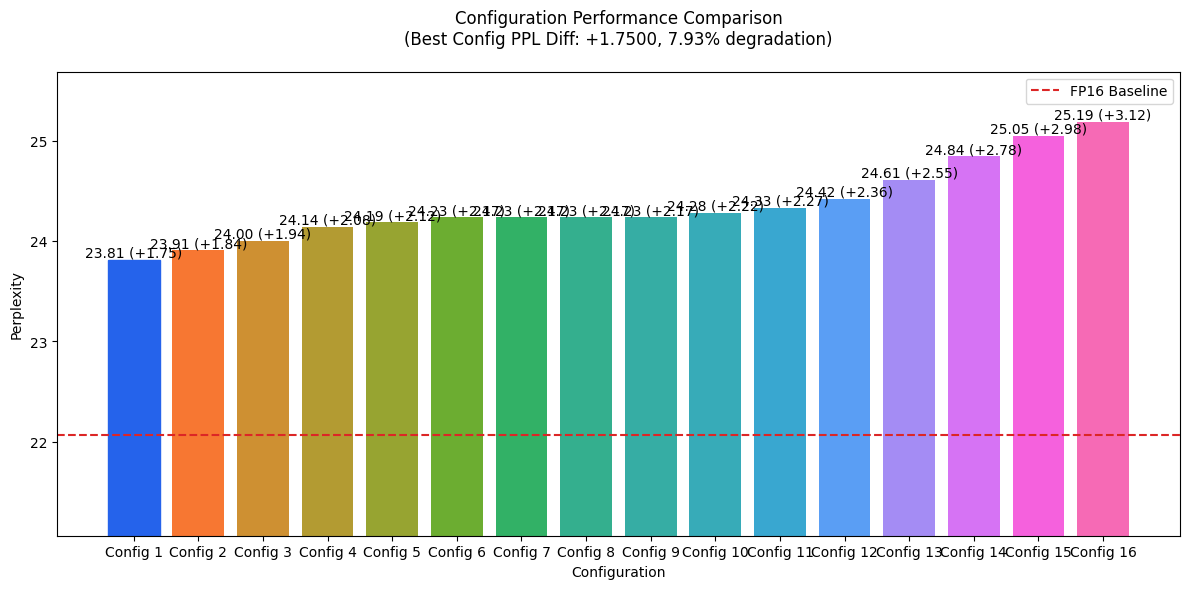

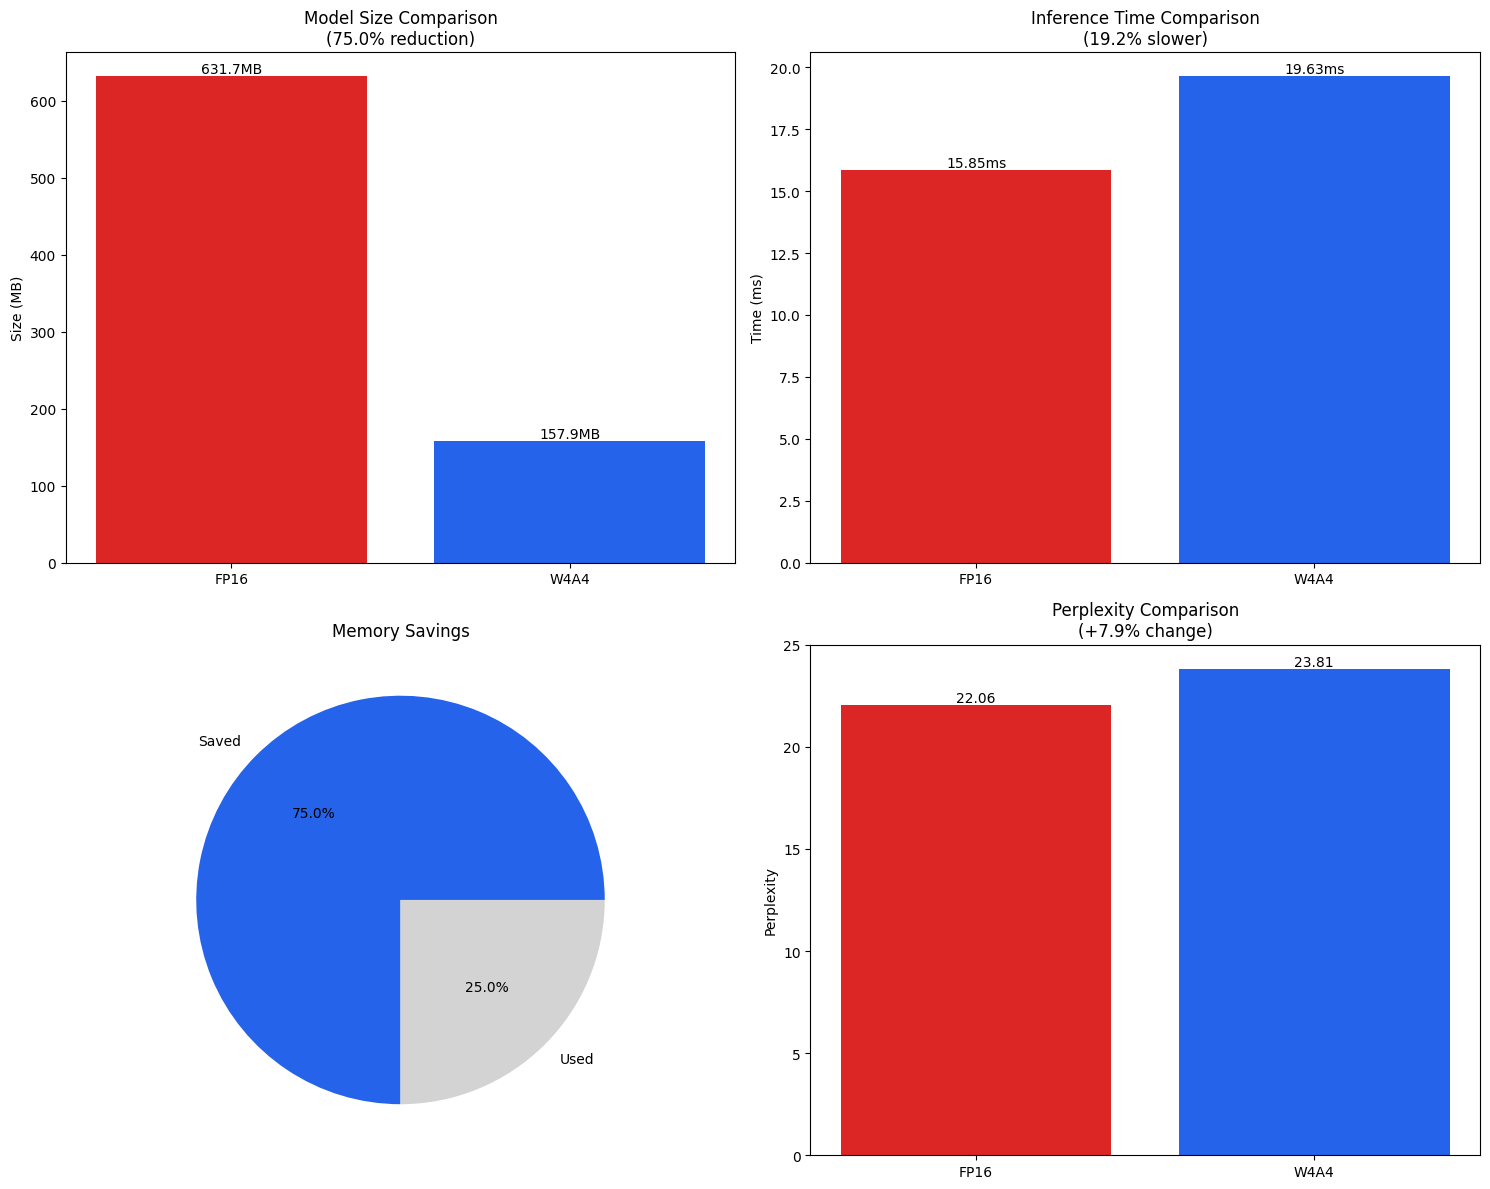


Model saved successfully to best_w4a4_model
Configuration saved to best_w4a4_model/config.json

Would you like to run the interactive demo? (yes/no): no


In [ ]:
# ======================
# Main Training Pipeline
# ======================
try:
    # Initialize logger
    logging.info("Starting W4A4 Quantization Pipeline")

    # Set device and seeds
    torch.manual_seed(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True

    logging.info(f"Using device: {device}")

    # Initialize model and tokenizer
    logging.info("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['MODEL_ID'])
    tokenizer.pad_token = tokenizer.eos_token

    fp16_model = OPTForCausalLM.from_pretrained(
        CONFIG['MODEL_ID'],
        torch_dtype=torch.float16,
        device_map="auto"
    )

    # Evaluate FP16 baseline
    logging.info("Evaluating FP16 baseline...")
    fp16_mean, fp16_std, _ = evaluate_perplexity(
        fp16_model,
        tokenizer,
        "FP16-Baseline",
        num_runs=1
    )

    # Prepare calibration data
    logging.info("Preparing calibration data...")
    calib_data = prepare_calibration_data(tokenizer)
    calib_data = {k: v.to(device) for k, v in calib_data.items()}

    results = []
    best_config = None
    best_ppl_diff = float('inf')
    best_model_store = None

    # Test configurations
    for i, config in enumerate(CONFIG['TRAINING_CONFIGS'], 1):
        try:
            logging.info(f"\nEvaluating configuration {i}/{len(CONFIG['TRAINING_CONFIGS'])}:")
            for param, value in config.items():
                logging.info(f"{param}: {value}")

            # Initialize quantizer
            quantizer = W4A4Quantizer(
                base_group_size=config['group_size'],
                percentile=config['percentile'],
                importance_threshold=config['importance_threshold'],
                scale_factor=config['scale_factor']
            )

            # Create and calibrate model
            current_model = QuantizedOPT(
                OPTForCausalLM.from_pretrained(
                    CONFIG['MODEL_ID'],
                    torch_dtype=torch.float16,
                    device_map="auto"
                ),
                quantizer,
                calibrate=True,
                calib_data=calib_data
            ).to(device)

            # Evaluate configuration
            current_ppl, current_std, current_runs = evaluate_perplexity(
                current_model,
                tokenizer,
                f"Config-{i}",
                num_runs=1
            )

            config_result = {
                'config': config,
                'perplexity': current_ppl,
                'std': current_std,
                'runs': current_runs
            }

            results.append(config_result)

            # Update best configuration if better
            ppl_diff = abs(current_ppl - fp16_mean)
            if ppl_diff < best_ppl_diff:
                logging.info("New best configuration found!")
                best_ppl_diff = ppl_diff
                best_config = config
                best_config_result = config_result
                if best_model_store is not None:
                    del best_model_store
                best_model_store = {'model': current_model, 'quantizer': quantizer}

            # Clean up if not best model
            if current_model != best_model_store['model']:
                del current_model
                torch.cuda.empty_cache()

        except Exception as e:
            logging.error(f"Error evaluating config {i}: {str(e)}")
            traceback.print_exc()
            continue

    if best_model_store is None:
        raise RuntimeError("No valid configuration found")

    # Collect final metrics
    logging.info("\nCollecting final metrics...")
    metrics = collect_comprehensive_metrics(
        fp16_model,
        best_model_store['model'],
        tokenizer,
        best_model_store['quantizer'],
        fp16_mean,
        best_config_result['perplexity']
    )

    # Save results
    experiment_results = {
        'baseline': {
            'perplexity': fp16_mean,
            'std': fp16_std
        },
        'best_config': best_config_result,
        'final_metrics': metrics
    }

    save_results(experiment_results)

    # Print final summary
    print_summary(best_config, fp16_mean, best_config_result, best_ppl_diff, metrics)

    # Create visualizations
    logging.info("\nCreating visualizations...")
    create_visualization(results, fp16_mean, metrics)
    logging.info("Visualizations saved in ./figures directory")

    # Save best model
    try:
        logging.info("\nSaving best model...")
        if best_model_store is not None:
            best_model_store['model'].save_model("best_w4a4_model")
            logging.info("Model saved successfully")
        else:
            logging.warning("No best model to save")
    except Exception as e:
        logging.error(f"Error saving model: {str(e)}")
        traceback.print_exc()

    # Optional interactive demo
    run_demo = input("\nWould you like to run the interactive demo? (yes/no): ").lower()
    if run_demo in ['yes', 'y']:
        interactive_demo(fp16_model, best_model_store['model'], tokenizer)

except Exception as e:
    logging.error(f"Error in main pipeline: {str(e)}")
    traceback.print_exc()

finally:
    # Clean up
    logging.info("\nCleaning up...")
    if 'fp16_model' in locals():
        del fp16_model
    if 'best_model_store' in locals():
        del best_model_store
    torch.cuda.empty_cache()